# Finetuning

This tutorial illustrates how to fine-tune the `GR00T-N1.5` pretrained checkpoint on a post-training 
dataset using the same embodiment. This showcases the benefit of post-training, transforming a generalist model into a specialist and demonstrating a performance gain.

GR00T-N1.5 openly supports the following embodiments:

| Embodiment Tag | Description |
|----------------|-------------|
| gr1 | The GR1 dataset |
| oxe_droid | The OxE Droid dataset |
| agibot_genie1 | The AgiBot Genie-1 with gripper dataset |
| new_embodiment | Any new embodiment for finetuning |

> Refer to the [Embodiment Tags](../gr00t/data/embodiment_tags.py) for more details.


For this tutorial, we will use the demo dataset `robot_sim.PickNPlace` from the [demo_data](./demo_data) folder. 

We will first load the pre-trained model and evaluate it on the dataset. Then we will finetune the model on the dataset and evaluate the performance.

## Pre-trained Model

In [1]:
from gr00t.utils.eval import calc_mse_for_single_trajectory
import warnings
from gr00t.experiment.data_config import DATA_CONFIG_MAP
from gr00t.model.policy import Gr00tPolicy
from gr00t.data.schema import EmbodimentTag
from gr00t.data.dataset import LeRobotSingleDataset
import numpy as np
import torch

device = "mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

warnings.simplefilter("ignore", category=FutureWarning)

objc[24133]: Class AVFFrameReceiver is implemented in both /opt/anaconda3/envs/Isaac-GR00T/lib/python3.10/site-packages/av/.dylibs/libavdevice.60.3.100.dylib (0x11edec760) and /opt/anaconda3/envs/Isaac-GR00T/lib/python3.10/site-packages/decord/.dylibs/libavdevice.59.7.100.dylib (0x30d470a10). This may cause spurious casting failures and mysterious crashes. One of the duplicates must be removed or renamed.
objc[24133]: Class AVFAudioReceiver is implemented in both /opt/anaconda3/envs/Isaac-GR00T/lib/python3.10/site-packages/av/.dylibs/libavdevice.60.3.100.dylib (0x11edec7b0) and /opt/anaconda3/envs/Isaac-GR00T/lib/python3.10/site-packages/decord/.dylibs/libavdevice.59.7.100.dylib (0x30d470a60). This may cause spurious casting failures and mysterious crashes. One of the duplicates must be removed or renamed.
/opt/anaconda3/envs/Isaac-GR00T/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.18). Upgrad

Using device: mps


Fetching 14 files:   0%|          | 0/14 [00:00<?, ?it/s]

Loading pretrained dual brain from /Users/apple/.cache/huggingface/hub/models--nvidia--GR00T-N1.5-3B/snapshots/b636b0d51a6c4514d39e1e88b8f04c15a74933b2
Tune backbone vision tower: True
Tune backbone LLM: False
Tune action head projector: True
Tune action head DiT: True
Model not found or avail in the huggingface hub. Loading from local path: /Users/apple/.cache/huggingface/hub/models--nvidia--GR00T-N1.5-3B/snapshots/b636b0d51a6c4514d39e1e88b8f04c15a74933b2
Tune backbone llm: False
Tune backbone visual: True
Total number of DiT parameters:  550386688
Tune backbone llm: False
Tune backbone visual: True
Total number of DiT parameters:  550386688
Total number of SelfAttentionTransformer parameters:  201433088
Tune action head projector: True
Tune action head diffusion model: True
Total number of SelfAttentionTransformer parameters:  201433088
Tune action head projector: True
Tune action head diffusion model: True


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Tune backbone llm: False
Tune backbone visual: True
Tune action head projector: True
Tune action head diffusion model: True
Initialized dataset robot_sim.PickNPlace with EmbodimentTag.GR1
inferencing at step:  0
Initialized dataset robot_sim.PickNPlace with EmbodimentTag.GR1
inferencing at step:  0
inferencing at step:  16
inferencing at step:  16
inferencing at step:  32
inferencing at step:  32
inferencing at step:  48
inferencing at step:  48
inferencing at step:  64
inferencing at step:  64
inferencing at step:  80
inferencing at step:  80
inferencing at step:  96
inferencing at step:  96
inferencing at step:  112
inferencing at step:  112
inferencing at step:  128
inferencing at step:  128
inferencing at step:  144
inferencing at step:  144
Unnormalized Action MSE across single traj: 1.13009844740367
state_joints vs time (150, 13)
gt_action_joints vs time (150, 13)
pred_action_joints vs time (150, 13)
Unnormalized Action MSE across single traj: 1.13009844740367
state_joints vs tim

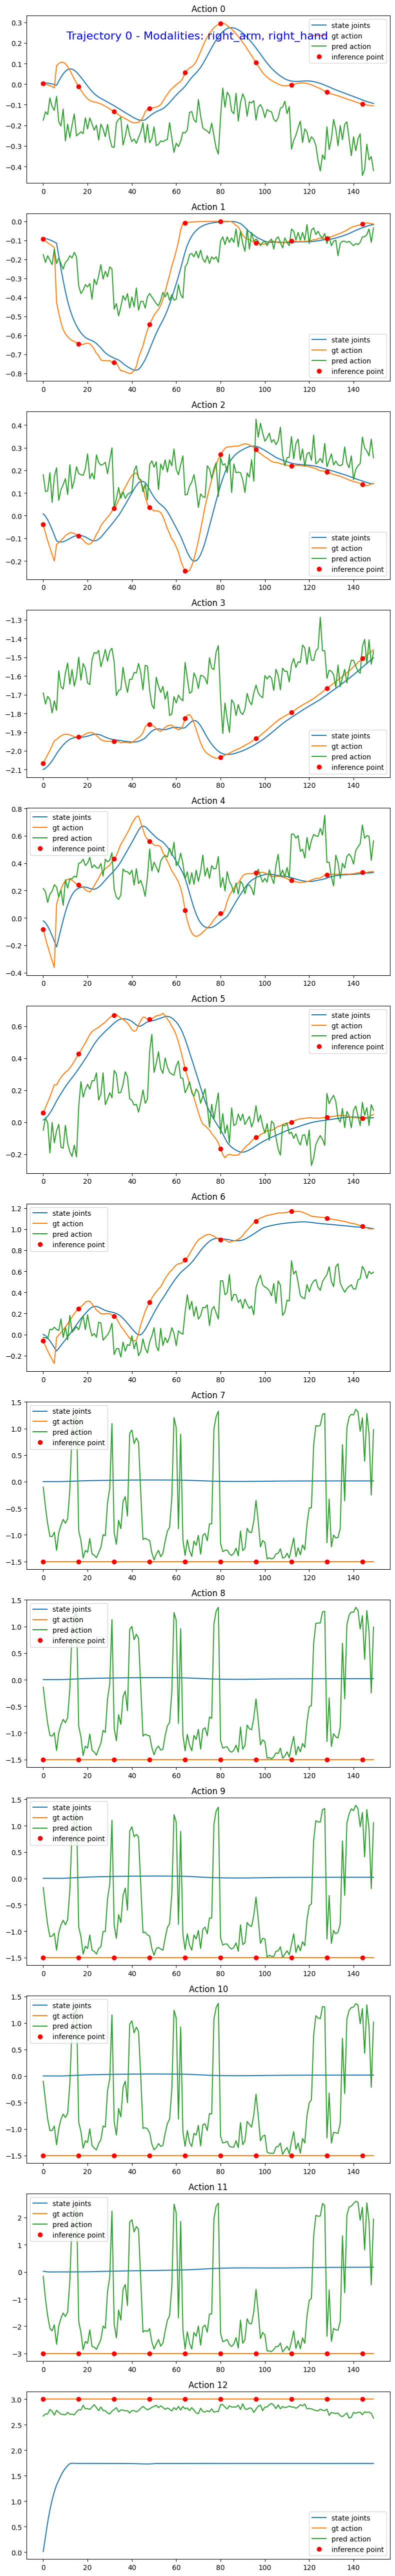

MSE loss for trajectory 0: 1.13009844740367


In [2]:
PRE_TRAINED_MODEL_PATH = "nvidia/GR00T-N1.5-3B"
EMBODIMENT_TAG = EmbodimentTag.GR1
DATASET_PATH = "../demo_data/robot_sim.PickNPlace"


data_config = DATA_CONFIG_MAP["fourier_gr1_arms_only"]
modality_config = data_config.modality_config()
modality_transform = data_config.transform()


pre_trained_policy = Gr00tPolicy(
    model_path=PRE_TRAINED_MODEL_PATH,
    embodiment_tag=EMBODIMENT_TAG,
    modality_config=modality_config,
    modality_transform=modality_transform,
    device=device,
)

dataset = LeRobotSingleDataset(
    dataset_path=DATASET_PATH,
    modality_configs=modality_config,
    video_backend="decord",
    video_backend_kwargs=None,
    transforms=None,  # We'll handle transforms separately through the policy
    embodiment_tag=EMBODIMENT_TAG,
)


mse = calc_mse_for_single_trajectory(
    pre_trained_policy,
    dataset,
    traj_id=0,
    modality_keys=["right_arm", "right_hand"],   # we will only evaluate the right arm and right hand
    steps=150,
    action_horizon=16,
    plot=True
)

print("MSE loss for trajectory 0:", mse)

Great! we can see the predicted actions and the ground truth actions. The predicted actions are not perfect but they are close to the ground truth actions. That's show that the pretrained checkpoint is working well.

Now let's sample 10 random trajectories and calcuate the mean MSE to get a sense of more verbose results.

In [3]:
total_trajectories = len(dataset.trajectory_lengths)

print("Total trajectories:", total_trajectories)

sampled_trajectories = np.random.choice(total_trajectories, 10)
print("Sampled trajectories:", sampled_trajectories)

all_mses = []

for traj_id in sampled_trajectories:
    mse = calc_mse_for_single_trajectory(
        pre_trained_policy,
        dataset,
        traj_id=traj_id,
        modality_keys=["right_arm", "right_hand"],   # we will only evaluate the right arm and right hand
        steps=150,
        action_horizon=16,
        plot=False
    )
    print(f"Trajectory {traj_id} MSE: {mse:.4f}")
    
    all_mses.append(mse)

print("====================================")
print("Mean MSE:", np.mean(all_mses))
print("Std MSE:", np.std(all_mses))


Total trajectories: 5
Sampled trajectories: [1 3 1 0 4 0 1 2 2 4]
inferencing at step:  0
inferencing at step:  16
inferencing at step:  16
inferencing at step:  32
inferencing at step:  32
inferencing at step:  48
inferencing at step:  48
inferencing at step:  64
inferencing at step:  64
inferencing at step:  80
inferencing at step:  80
inferencing at step:  96
inferencing at step:  96
inferencing at step:  112
inferencing at step:  112
inferencing at step:  128
inferencing at step:  128
inferencing at step:  144
inferencing at step:  144
Unnormalized Action MSE across single traj: 1.4637150506725543
state_joints vs time (150, 13)
gt_action_joints vs time (150, 13)
pred_action_joints vs time (150, 13)
Trajectory 1 MSE: 1.4637
inferencing at step:  0
Unnormalized Action MSE across single traj: 1.4637150506725543
state_joints vs time (150, 13)
gt_action_joints vs time (150, 13)
pred_action_joints vs time (150, 13)
Trajectory 1 MSE: 1.4637
inferencing at step:  0
inferencing at step:  16

## Finetuning the Model

Now we will finetune the model on the dataset. Without going into the details of the finetuning process, we will use the `gr00t_finetune.py` script to finetune the model. You can run the following command to finetune the model. 

```bash
python scripts/gr00t_finetune.py \
    --dataset-path ./demo_data/robot_sim.PickNPlace \
    --num-gpus 1 \
    --max-steps 500 \
    --output-dir /tmp/gr00t-1/finetuned-model \
    --data-config gr1_arms_only
```

_To get a full list of the available arguments, you can run `python scripts/gr00t_finetune.py --help`._

The script will save the finetuned model in the `/tmp/gr00t-1/finetuned-model` directory. We will load the finetuned model with `500` checkpoint steps.  

### Evaluation of the Fine-tuned Model

Now we can evaluate the fine-tuned model by running the policy on the dataset and see how well it performs. We will use a utility function to evaluate the policy on the dataset. This is similar to the previous tutorial in [1_pretrained_model.ipynb](1_pretrained_model.ipynb)

Loading from local path: /tmp/gr00t-1/finetuned-model/checkpoint-500
Loading pretrained dual brain from /tmp/gr00t-1/finetuned-model/checkpoint-500
Tune backbone vision tower: True
Tune backbone LLM: False
Tune action head projector: True
Tune action head DiT: True
Model not found or avail in the huggingface hub. Loading from local path: /tmp/gr00t-1/finetuned-model/checkpoint-500
Tune backbone llm: False
Tune backbone visual: True
Total number of DiT parameters:  550386688
Total number of SelfAttentionTransformer parameters:  201433088
Tune action head projector: True
Tune action head diffusion model: True
Total number of SelfAttentionTransformer parameters:  201433088
Tune action head projector: True
Tune action head diffusion model: True


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Tune backbone llm: False
Tune backbone visual: True
Tune action head projector: True
Tune action head diffusion model: True
inferencing at step:  0
inferencing at step:  0
inferencing at step:  16
inferencing at step:  16
inferencing at step:  32
inferencing at step:  32
inferencing at step:  48
inferencing at step:  48
inferencing at step:  64
inferencing at step:  64
inferencing at step:  80
inferencing at step:  80
inferencing at step:  96
inferencing at step:  96
inferencing at step:  112
inferencing at step:  112
inferencing at step:  128
inferencing at step:  128
inferencing at step:  144
inferencing at step:  144
Unnormalized Action MSE across single traj: 0.06900458751292307
state_joints vs time (150, 13)
gt_action_joints vs time (150, 13)
pred_action_joints vs time (150, 13)
Unnormalized Action MSE across single traj: 0.06900458751292307
state_joints vs time (150, 13)
gt_action_joints vs time (150, 13)
pred_action_joints vs time (150, 13)


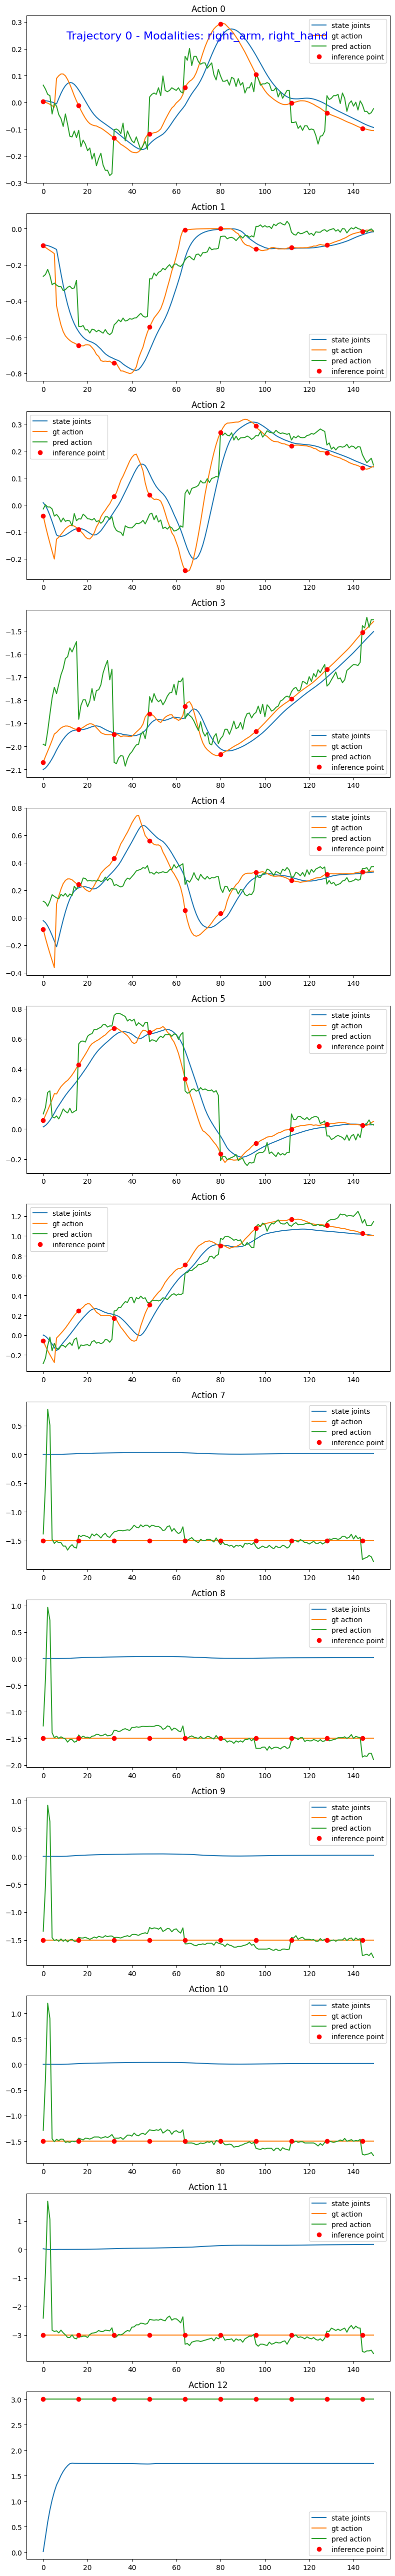

MSE loss for trajectory 0: 0.06900458751292307


In [7]:
from gr00t.utils.eval import calc_mse_for_single_trajectory
import warnings

finetuned_model_path = "/tmp/gr00t-1/finetuned-model/checkpoint-500"
finetuned_policy = Gr00tPolicy(
    model_path=finetuned_model_path,
    embodiment_tag="new_embodiment",
    modality_config=modality_config,
    modality_transform=modality_transform,
    device=device,
)

warnings.simplefilter("ignore", category=FutureWarning)

mse = calc_mse_for_single_trajectory(
    finetuned_policy,
    dataset,
    traj_id=0,
    modality_keys=["right_arm", "right_hand"],   # we will only evaluate the right arm and right hand
    steps=150,
    action_horizon=16,
    plot=True
)

print("MSE loss for trajectory 0:", mse)

Yaay! We have finetuned the model and evaluated it on the dataset. We can see that the model has learned the task and is able to perform the task better than the pre-trained model.